In [81]:
import os
from pathlib import Path
from PIL import Image
from my_functions_new import *

# Define whether to filter out values <0.1
remove_little_values = True

In [53]:
### Define the names of the methods, and the shorthand versions of the names used in the folder naming conventions
rainfall_scenario_names =  {'singlepeak' : 'sp', 'dividetime' : 'dt', 'subpeaktiming' : 'sp-t', 'maxspread': 'ms'}

In [55]:
sp_depth_fp = "MeganModel/6hr_sp_u/6hr_singlepeak_depth.Resampled.Terrain.tif"
sp_fp = "MeganModel/6hr_sp_u/6hr_singlepeak_{}.Resampled.Terrain.tif"
fps = ["MeganModel/6hr_ms_u/6hr_maxspread_{}.Resampled.Terrain.tif",
       "MeganModel/6hr_sp-t_u/6hr_subpeaktiming_{}.Resampled.Terrain.tif",
       "MeganModel/6hr_dt_u/6hr_dividetime_{}.Resampled.Terrain.tif"]

In [56]:
# Define breaks to split the depths/velocities on
breaks_depths = np.array([0, 0.3, 0.6, 1.2, 100])  
labels_depth = ['<=0.3m', '0.3-0.6m', '0.6-1.2m', '>1.2m']
breaks_velocity = np.array([0,0.25,0.5,2,100])
labels_velocity = ["<=0.25m/s", "0.25-0.5m/s", "0.5-2m/s", ">2m/s"]

velocity_counts, velocity_props = create_binned_counts_and_props(fps+[sp_fp], 'velocity', breaks_velocity, labels_velocity, remove_little_values)
depth_counts, depth_props = create_binned_counts_and_props(fps+[sp_fp], 'depth', breaks_depths, labels_depth, remove_little_values)

#  Flood extent 
To examine whether the rainfall's temporal distribution influences the total extent of flooding, the number of flooded cells and the total flooded area in km2 (incl. only cells with depth >0.1m) is compared between the profile with a single peak, and the three methods for producing multi-peaked rainfall events. 

In [57]:
# Create one dataframe with each column the total number of flooded cells for each method 
totals_df =pd.DataFrame(depth_counts.sum(numeric_only=True)).T
totals_df = totals_df.iloc[[len(totals_df)-1]]
# Convert this to the total flooded area for each method
totals_df_area = (totals_df * 25)/1000000

In [58]:
# Get a list of the percentage difference between the total number of flooded cells with a single peak and the methods for
# creating multiple peaks
ls = []
for fp in fps+[sp_fp]:
    rainfall_scenario_name = fp.split('/')[1]
    if rainfall_scenario_name!= '6hr_sp_u':
        ls.append((totals_df[rainfall_scenario_name]/totals_df['6hr_sp_u'] - 1).values[0])
# Convert values to strings, and add a + sign for positive values
# Include an empty entry for the single peak scenario
ls =[''] + ['+' + str(round((list_item *100),2)) + '%' if list_item > 0 else str(round((list_item *100),2)) + '%'  for list_item in ls]

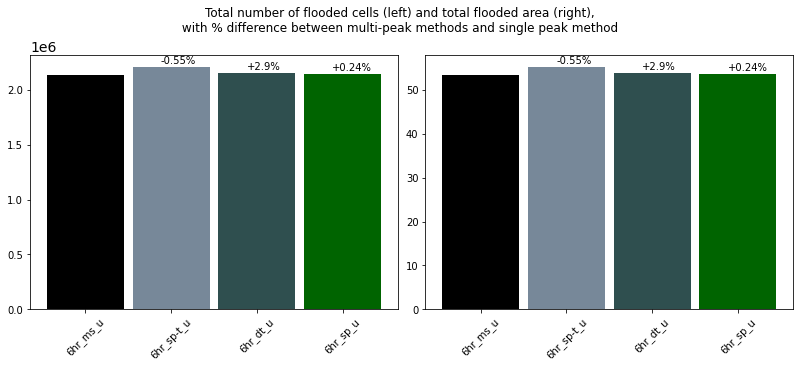

In [62]:
# Set colors for plots
colors = ['black', 'lightslategrey', 'darkslategrey', 'darkgreen']

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (11,5))
make_totals_bar_plot(axs[1], totals_df_area,'Flooded area (km2)', ls, colors)
make_totals_bar_plot(axs[0],totals_df, 'Number of flooded cells', ls, colors)
st = plt.suptitle ("Total number of flooded cells (left) and total flooded area (right),\n with % difference between multi-peak methods and single peak method ", fontsize = 12)

Text(0.5, 0.98, 'Number/proportion of cells flooded to various depth and velocity categories')

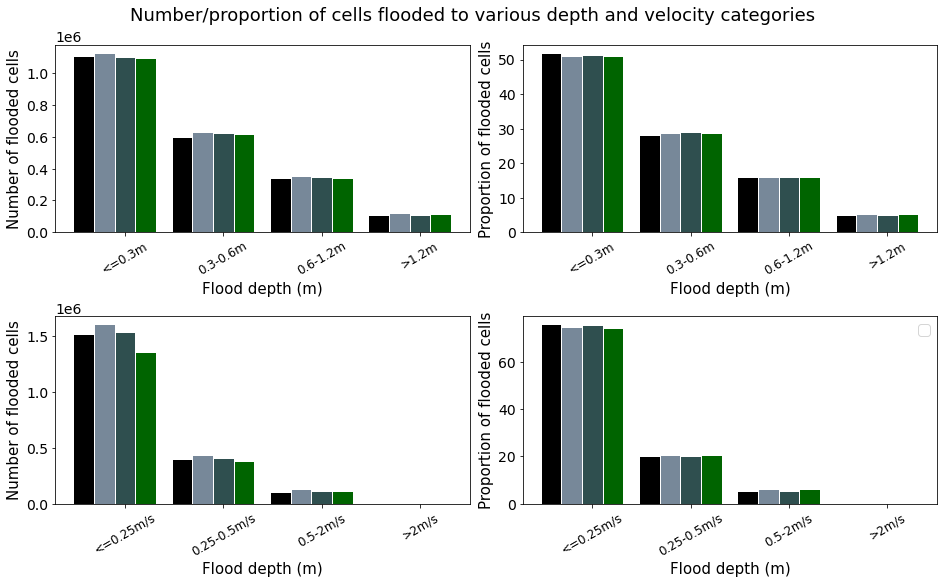

In [63]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize = (13,8))
make_bar_plot_by_category(axs[0,0], depth_counts, 'depth', 'm', 'Number of flooded cells', colors)
make_bar_plot_by_category(axs[0,1], depth_props, 'depth', 'm', 'Proportion of flooded cells', colors)
make_bar_plot_by_category(axs[1,0], velocity_counts, 'depth', 'm', 'Number of flooded cells', colors)
make_bar_plot_by_category(axs[1,1], velocity_props, 'depth', 'm', 'Proportion of flooded cells', colors)
fig.suptitle('Number/proportion of cells flooded to various depth and velocity categories', fontsize = 18)     

### Proportion of total num flooded cells from each depth/velocity category

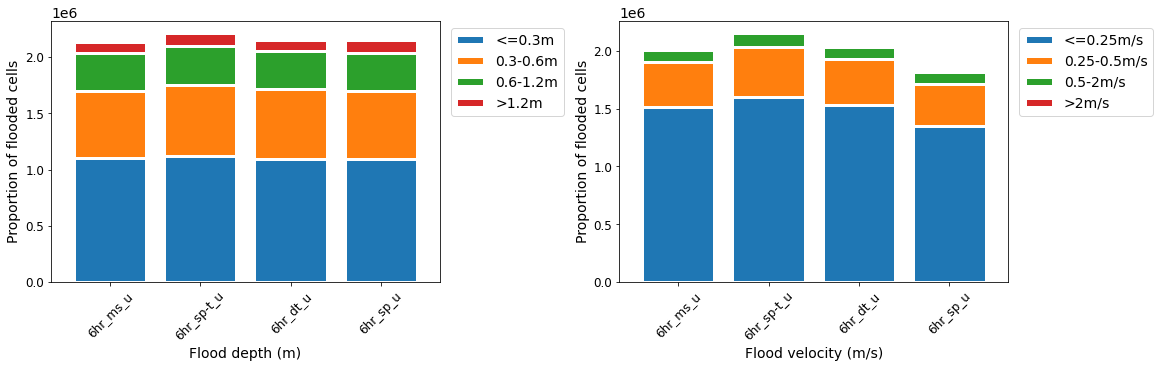

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (16,5))
make_props_plot(axs[0], depth_counts, 'depth', 'm', labels_depth)
make_props_plot(axs[1], velocity_counts, 'velocity', 'm/s', labels_velocity)

## Number of cells in which each method leads to the worst flooding (depth/velocity)
Check what happens in the case where the flood depth/velocity is equal

In [70]:
worst_case_method_depth = find_worst_case_method(fps, sp_fp, 'depth')
worst_case_method_velocity = find_worst_case_method(fps, sp_fp, 'velocity') 

Text(0.5, 0.98, 'Number cells where each method produces the deepest (left) and fastest (right) flooding')

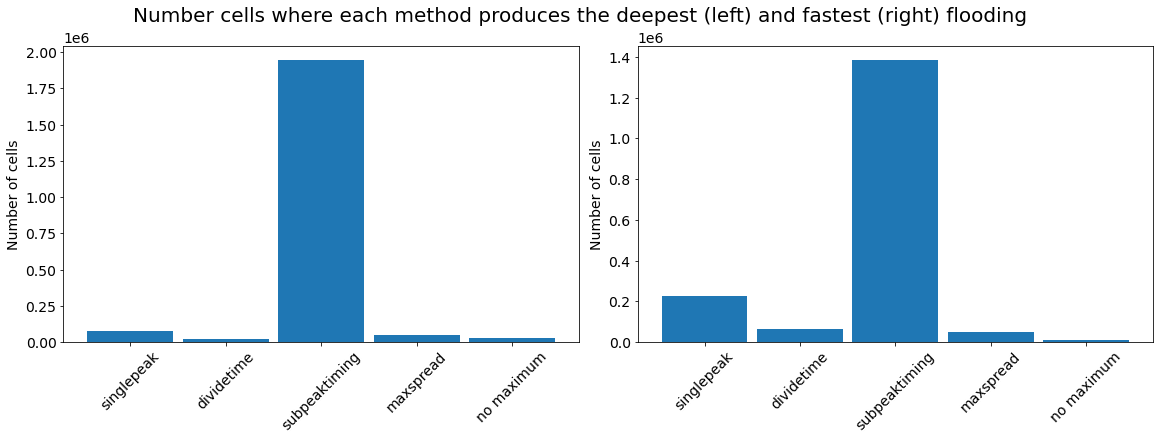

In [75]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (16,6))
plot_worst_case_bars(axs[0],worst_case_method_depth)
plot_worst_case_bars(axs[1],worst_case_method_velocity)
fig.suptitle('Number cells where each method produces the deepest (left) and fastest (right) flooding', fontsize = 20)

## Spatial extent of flooding, by depth category (for d >0.1m) for each rainfall distribution

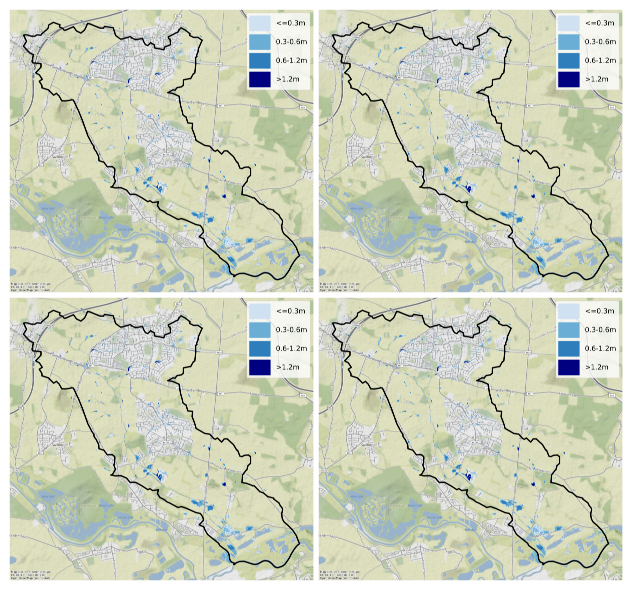

In [86]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(40,20))
for number, fp in enumerate(fps+[sp_fp]):
    fp = 'HecRas_Processing/Figs/' + fp.split('/')[1] +'/depth_classified.png'
    make_spatial_plot(axes.flat[number],fp)
                 
fig.tight_layout()
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.5, top=0.5, wspace=-0.6, hspace=0)

## Spatial extent of flooding, by velocity category (for d >0.1m) for each rainfall distribution

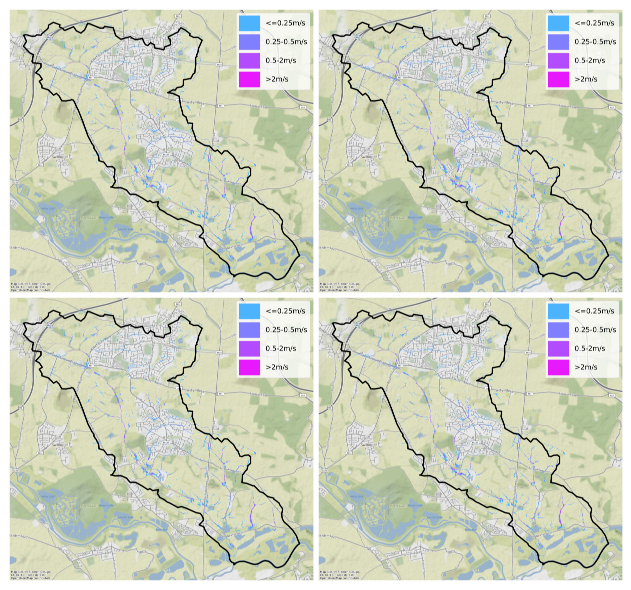

In [89]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(40,20))
for number, fp in enumerate(fps+[sp_fp]):
    fp = 'HecRas_Processing/Figs/' + fp.split('/')[1] +'/velocity_classified.png'
    make_spatial_plot(axes.flat[number],fp)
                 
fig.tight_layout()
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.5, top=0.5, wspace=-0.6, hspace=0)

In [27]:
# # Create discrete cmap
# colors_list = [mpl.cm.Blues(0.2), mpl.cm.Blues(0.5), mpl.cm.Blues(0.7),"navy"]
# cmap = mpl.colors.ListedColormap(colors_list)

# my_dict = {"dividetime":"Arcpy/depth_dividetime_reclassified.tif",
#            "maxspread":"Arcpy/depth_maxspread_reclassified.tif",
#            "subpeaktiming":"Arcpy/depth_subpeaktiming_reclassified.tif",
#            "singlepeak": "Arcpy/depth_singlepeak_reclassified.tif"}    

# plot_with_folium(my_dict, cmap, template_depth_cats)

In [28]:
# # Create discrete cmap
# colors_list = [mpl.cm.cool(0.3), mpl.cm.cool(0.5), mpl.cm.cool(0.7), mpl.cm.cool(0.9)]
# cmap2 = mpl.colors.ListedColormap(colors_list)

# my_dict = {"dividetime":"Arcpy/velocity_dividetime_reclassified.tif",
#            "maxspread":"Arcpy/velocity_maxspread_reclassified.tif",
#            "subpeaktiming":"Arcpy/velocity_subpeaktiming_reclassified.tif",
#            "singlepeak": "Arcpy/velocity_singlepeak_reclassified.tif"}    

# plot_with_folium(my_dict, cmap2, template = template_velocity_cats)

## Difference in flood depth between a single peak and each of the multi-peaked methods
A positive difference implies that the flooding is deeper in the single peak method, whilst a negative difference implies the opposite.

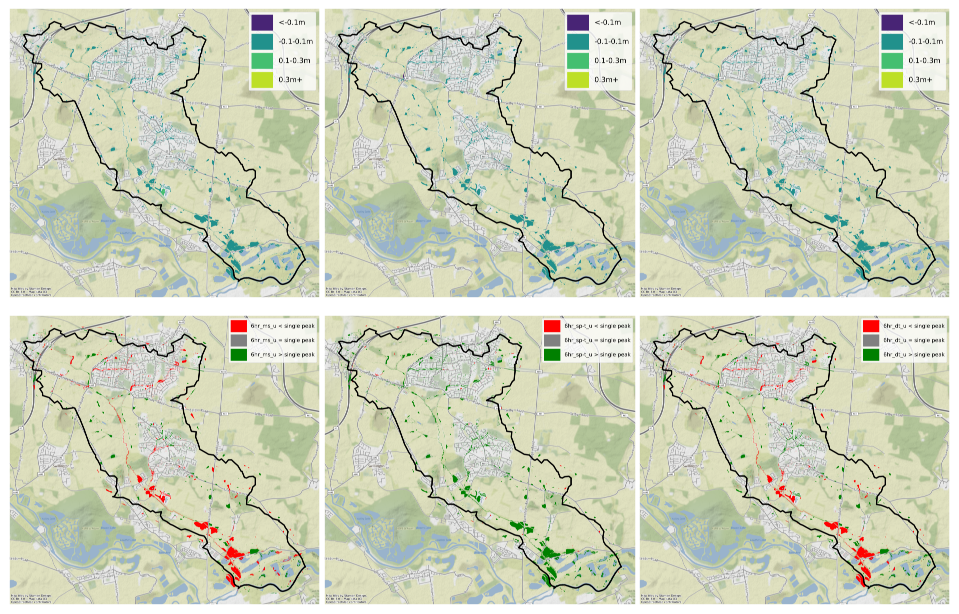

In [94]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(35,30))
for number, fp in enumerate(fps):
    fp = 'HecRas_Processing/Figs/' + fp.split('/')[1] +'/depth_difffromsinglepeak_classified.png'
    make_spatial_plot(axes.flat[number],fp)
for number, fp in enumerate(fps):
    fp = 'HecRas_Processing/Figs/' + fp.split('/')[1] +'/depth_difffromsinglepeak_posneg.png'
    make_spatial_plot(axes.flat[number+3],fp)    
fig.tight_layout()
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.5, top=0.5, wspace=0, hspace=-0.45)
